#### **Blog Generation Through Youtube Video**

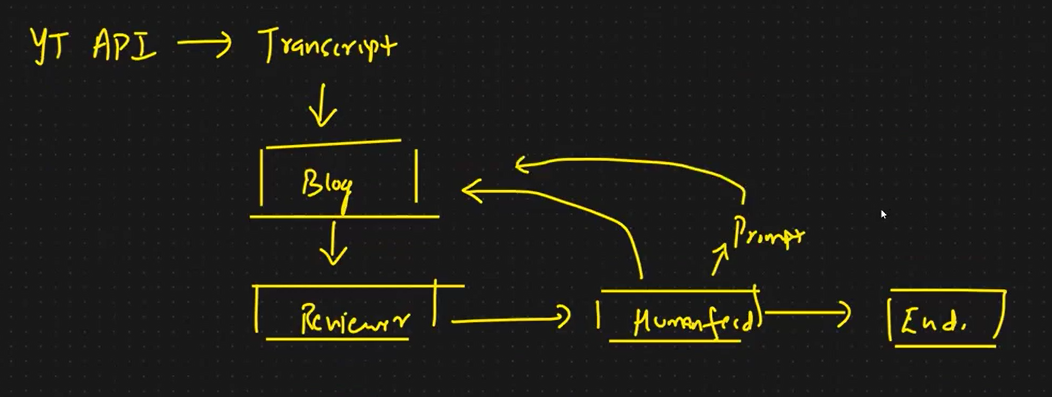

In [31]:
# Importing the required libraries
import os
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from typing_extensions import TypedDict, List, Annotated
from pydantic import BaseModel, Field
from langchain_community.document_loaders import YoutubeLoader
from langchain_community.document_loaders.youtube import TranscriptFormat
from langchain_groq import ChatGroq
from langchain_core.documents import Document
from langgraph.constants import Send
from langchain.text_splitter import RecursiveCharacterTextSplitter
import operator
load_dotenv()

True

In [2]:
# Loading the environment variable
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [3]:
# Loading the LLM model
llm = ChatGroq(model="qwen-2.5-32b",temperature=0)
llm.invoke("Hi! I am Hrishikesh")

AIMessage(content="Hello Hrishikesh! It's nice to meet you. How can I assist you today? Is there anything specific you would like to know or discuss?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 37, 'total_tokens': 70, 'completion_time': 0.165, 'prompt_time': 0.004225359, 'queue_time': 0.250463325, 'total_time': 0.169225359}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-05d1c299-b4ed-4f54-bf38-9b472df6ef42-0', usage_metadata={'input_tokens': 37, 'output_tokens': 33, 'total_tokens': 70})

In [ ]:
# Define the state
class State(TypedDict):
    youtube_url: str
    blogs_content:Annotated[list,operator.add]
    transcripts: List[Document]
    llm_review: str
    human_feedback: str
    blog: str
    

# TransciptState
class TransciptState(TypedDict):
    process_script: Document
    blog_content: Annotated[list,operator.add]

# ProcessTransciptState
class ProcessTransciptState(TypedDict):
    script: Document
    preprocess_transcripts: Annotated[list,operator.add]

# Review Model
class ReviewerModel(BaseModel):
    review: str = Field(description="Review the generated blog and suggest areas of improvement if required.")
    
LLMReviewer = llm.with_structured_output(ReviewerModel)

In [44]:
# Prompts
transcript_cleaner_prompt = """ 
You are an expert in language processing, transcription refinement, and content editing. 
Your goal is to correct and enhance a transcribed text by ensuring accuracy, coherence, readability, and proper formatting.

User Input:

Here is a raw transcript extracted from a YouTube video. It may contain errors, missing punctuation, misheard words,
and inconsistent formatting. Your task is to refine and enhance it while maintaining the original meaning.

Instructions:

Correct errors: Fix any words or phrases that seem out of context or were likely misheard by the transcription model.
Improve readability: Add proper punctuation, break up run-on sentences, and create meaningful paragraphs.
Maintain natural speech flow: Keep the tone conversational where applicable but ensure clarity and conciseness.
Preserve speaker intent: If certain words or phrases seem incorrect, infer the most likely intended meaning based on context only.
Remove filler words (if needed): Exclude unnecessary "um," "uh," "you know," etc., unless they are contextually significant.
Format properly: Ensure consistent capitalization, paragraph spacing, and logical segmentation. Only provide the transcript do not mention anything, like "Here is the transcript of the video"
Highlight uncertainties: If any part of the transcript seems unclear or ambiguous, mark it with [UNCLEAR] and suggest possible alternatives.

Example Input:

"uh so today we're gonna like talk about um how to start a blog and stuff and uh it's like really important to like make sure you have uh the right topic you know? 
And um then you wanna like do some research and stuff uh before writing."

Example Output:
"Today, we're going to talk about how to start a blog. It's important to choose the right topic and do proper 
research before writing."
"""

blog_generation_prompt = """You are a expert in technical blog creation, your task is to generate the blog on the provided context.
"""

In [ ]:
def extract_transcript(state:State):
    
    print("------EXTRACTING TRANSCRIPT OF YOUTUBE VIDEO--------")
    loader = YoutubeLoader.from_youtube_url(
    youtube_url=state["youtube_url"],
    # transcript_format=TranscriptFormat.CHUNKS,
    # chunk_size_seconds= 300
    )
    transcripts = loader.load()
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=400)
    docs = text_splitter.split_documents(transcripts)
    return {"transcripts":docs}

def continue_to_preprocessing(state: State):
    return [Send("preprocess_transcript", {"script": script}) for script in state["transcripts"]]

def preprocess_transcript(state:ProcessTransciptState):
    
    print("------PREPROCESS TRANSCRIPT--------")
    system_message = SystemMessage(content=transcript_cleaner_prompt)
    transcript = llm.invoke([system_message]+[HumanMessage(content=f"Clean the provided transcript document of youtube video : {state['script'].page_content}")])
    return {"preprocess_transcripts":[transcript]}

def continue_to_generating(state: ProcessTransciptState):
    
    return [Send("generate_blog_content",{"process_script": pro_script}) for pro_script in state["preprocess_transcripts"]]

def generate_blog_content(state:TransciptState):
    """Worker writes a section of the report"""

    print("------- GENERATING THE BLOG CONTENT ---------")
    # Generate section

    blog_content = llm.invoke(
        [
            SystemMessage(
                content="Write a blog's paragraph using provided transcript. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the transcript : {state['process_script']}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"blogs_content": [blog_content]}


def synthesizer(state: State):
    """Synthesize full blog from transcripts"""

    print("------Aggregating the transcripts-------")
    # List of completed transcripts
    blogs_content = state["blogs_content"]

    # Format completed section to str to use as context for final sections
    blogs_content = "\n\n---\n\n".join(blogs_content)

    return {"blog": blogs_content}

In [80]:
from PIL import Image
blog_workflow = StateGraph(State)

# Add the nodes
blog_workflow.add_node("extract_transcript", extract_transcript)
blog_workflow.add_node("preprocess_transcript", preprocess_transcript)
blog_workflow.add_node("generate_blog_content", generate_blog_content)
blog_workflow.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
blog_workflow.add_edge(START, "extract_transcript")
blog_workflow.add_conditional_edges(
    "extract_transcript", continue_to_preprocessing, ["preprocess_transcript"]
)
blog_workflow.add_conditional_edges(
    "preprocess_transcript", continue_to_generating, ["generate_blog_content"]
)
blog_workflow.add_edge("generate_blog_content", "synthesizer")
blog_workflow.add_edge("synthesizer", END)

# Compile the workflow
blogger = blog_workflow.compile()

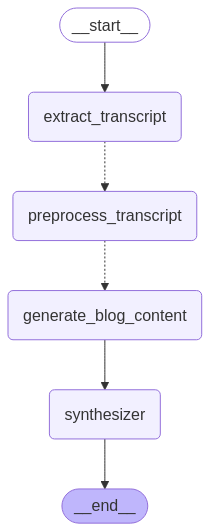

In [81]:
blogger

In [ ]:
state = blogger.invoke({"youtube_url": "https://youtu.be/e1rl1DYfPy4?si=csTa-TPFKtmgJNuK"})

from IPython.display import Markdown
Markdown(state["blog"])

------EXTRACTING TRANSCRIPT OF YOUTUBE VIDEO--------
------PREPROCESS TRANSCRIPT--------
------PREPROCESS TRANSCRIPT--------
------PREPROCESS TRANSCRIPT--------
------PREPROCESS TRANSCRIPT--------
------PREPROCESS TRANSCRIPT--------
------PREPROCESS TRANSCRIPT--------
------PREPROCESS TRANSCRIPT--------
------PREPROCESS TRANSCRIPT--------
ProcessTransciptState :  {'script': Document(metadata={'source': 'e1rl1DYfPy4'}, page_content="see the API endpoint looks something like this where there is HTTP SL whatever you give your data you give your data such as okay what is my age what is my income what is my loan amount and in response it will tell you this it will say your default probability is 90% score is this rating is poor and so on now when we did this credit risk modeling project we used streamlet in streamlet you can quickly prototype these applications but in real life uh for Enterprise applications people don't use streamlet they use Frameworks such as react for example they might